In [4]:
import numpy as np
import torch

from qecdec import RotatedSurfaceCode, detector_error_model_to_check_matrices
from learned_decoders import *
from train_utils import *

d = 5
p = 0.01
# num_bp_iters = 5
# learning_rate = 0.002
num_bp_iters = 8
loss_iters = [4, 5, 6, 7]
learning_rate = 0.001

beta = 1.0

In [5]:
code = RotatedSurfaceCode(d=d)
circuit = code.make_circuit_memory_z_experiment(
    rounds=d,
    data_qubit_error_rate=p,
    meas_error_rate=p,
    # prep_error_rate=p,
    # gate1_error_rate=p,
    # gate2_error_rate=p,
    keep_z_detectors_only=True
)
dem = circuit.detector_error_model()
matrices = detector_error_model_to_check_matrices(dem)
chkmat = matrices.check_matrix.toarray().astype(np.uint8)
obsmat = matrices.observables_matrix.toarray().astype(np.uint8)
prior = matrices.priors.astype(np.float64)

print("Number of error mechanisms:", chkmat.shape[1])
print("Number of detectors:", chkmat.shape[0])
print("Number of observables:", obsmat.shape[0])

Number of error mechanisms: 186
Number of detectors: 72
Number of observables: 1


In [6]:
train_dataset, val_dataset = build_datasets(
    dem,
    train_shots=10_000,
    val_shots=1_000,
    seed=42,
)
print("Size of train_dataset:", len(train_dataset))
print("Size of val_dataset:", len(val_dataset))

model = LearnedDMemBP(chkmat, prior, num_iters=num_bp_iters, min_impl_method="smooth", sign_impl_method="smooth")
# model = LearnedDMemBP(chkmat, prior, num_iters=num_bp_iters, min_impl_method="hard", sign_impl_method="hard")
# model = LearnedDOffBP(chkmat, prior, num_iters=num_bp_iters, min_impl_method="hard", sign_impl_method="hard")
loss_fn = DecodingLoss(chkmat, obsmat, beta=beta, loss_iters=loss_iters)
metric = DecodingMetric(chkmat, obsmat)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Size of train_dataset: 25556
Size of val_dataset: 815


In [7]:
train_gamma(
    model,
    train_dataset,
    val_dataset,
    loss_fn,
    metric,
    optimizer,
    num_epochs=50,
    batch_size=256,
    device="cpu",
    scheduler_kwargs=dict(factor=0.2, patience=3, threshold=1e-3, threshold_mode="abs"),
    early_stopper=EarlyStopper(patience=5, min_delta=1e-3),
)

Using cpu device


Epoch 1/50: 100%|██████████| 100/100 [09:49<00:00,  5.90s/it, avg_loss=0.336768, grad_norm=0.493046]


Epoch 1 Summary:
  Avg Train Loss: 0.336768
  Avg Val Loss: 0.355080
  wrong_syndrome_rate: 0.041718
  wrong_observable_rate: 0.003681
  failure_rate: 0.042945
  Learning Rate: 0.001000



Epoch 2/50: 100%|██████████| 100/100 [43:26<00:00, 26.06s/it, avg_loss=0.263088, grad_norm=0.364045]  


Epoch 2 Summary:
  Avg Train Loss: 0.263088
  Avg Val Loss: 0.283740
  wrong_syndrome_rate: 0.039264
  wrong_observable_rate: 0.004908
  failure_rate: 0.040491
  Learning Rate: 0.001000



Epoch 3/50: 100%|██████████| 100/100 [08:58<00:00,  5.39s/it, avg_loss=0.218783, grad_norm=0.300012]


Epoch 3 Summary:
  Avg Train Loss: 0.218783
  Avg Val Loss: 0.240784
  wrong_syndrome_rate: 0.030675
  wrong_observable_rate: 0.004908
  failure_rate: 0.031902
  Learning Rate: 0.001000



Epoch 4/50: 100%|██████████| 100/100 [08:56<00:00,  5.37s/it, avg_loss=0.189910, grad_norm=0.284244]


Epoch 4 Summary:
  Avg Train Loss: 0.189910
  Avg Val Loss: 0.213106
  wrong_syndrome_rate: 0.020859
  wrong_observable_rate: 0.003681
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 5/50: 100%|██████████| 100/100 [09:04<00:00,  5.44s/it, avg_loss=0.169803, grad_norm=0.225923]


Epoch 5 Summary:
  Avg Train Loss: 0.169803
  Avg Val Loss: 0.195613
  wrong_syndrome_rate: 0.020859
  wrong_observable_rate: 0.004908
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 6/50: 100%|██████████| 100/100 [09:11<00:00,  5.52s/it, avg_loss=0.155173, grad_norm=0.258300]


Epoch 6 Summary:
  Avg Train Loss: 0.155173
  Avg Val Loss: 0.184986
  wrong_syndrome_rate: 0.018405
  wrong_observable_rate: 0.004908
  failure_rate: 0.019632
  Learning Rate: 0.001000



Epoch 7/50: 100%|██████████| 100/100 [09:13<00:00,  5.54s/it, avg_loss=0.143740, grad_norm=0.285132]


Epoch 7 Summary:
  Avg Train Loss: 0.143740
  Avg Val Loss: 0.177916
  wrong_syndrome_rate: 0.017178
  wrong_observable_rate: 0.003681
  failure_rate: 0.018405
  Learning Rate: 0.001000



Epoch 8/50: 100%|██████████| 100/100 [09:11<00:00,  5.52s/it, avg_loss=0.134260, grad_norm=0.187984]


Epoch 8 Summary:
  Avg Train Loss: 0.134260
  Avg Val Loss: 0.171878
  wrong_syndrome_rate: 0.015951
  wrong_observable_rate: 0.003681
  failure_rate: 0.017178
  Learning Rate: 0.001000



Epoch 9/50: 100%|██████████| 100/100 [09:04<00:00,  5.45s/it, avg_loss=0.125684, grad_norm=0.248058]


Epoch 9 Summary:
  Avg Train Loss: 0.125684
  Avg Val Loss: 0.167345
  wrong_syndrome_rate: 0.017178
  wrong_observable_rate: 0.004908
  failure_rate: 0.018405
  Learning Rate: 0.001000



Epoch 10/50: 100%|██████████| 100/100 [09:07<00:00,  5.47s/it, avg_loss=0.118091, grad_norm=0.273541]


Epoch 10 Summary:
  Avg Train Loss: 0.118091
  Avg Val Loss: 0.163466
  wrong_syndrome_rate: 0.015951
  wrong_observable_rate: 0.003681
  failure_rate: 0.017178
  Learning Rate: 0.001000



Epoch 11/50: 100%|██████████| 100/100 [09:11<00:00,  5.52s/it, avg_loss=0.111498, grad_norm=0.279528]


Epoch 11 Summary:
  Avg Train Loss: 0.111498
  Avg Val Loss: 0.159761
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.002454
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 12/50: 100%|██████████| 100/100 [09:09<00:00,  5.49s/it, avg_loss=0.105540, grad_norm=0.179675]


Epoch 12 Summary:
  Avg Train Loss: 0.105540
  Avg Val Loss: 0.157093
  wrong_syndrome_rate: 0.017178
  wrong_observable_rate: 0.004908
  failure_rate: 0.018405
  Learning Rate: 0.001000



Epoch 13/50: 100%|██████████| 100/100 [40:11<00:00, 24.12s/it, avg_loss=0.100612, grad_norm=0.244458]  


Epoch 13 Summary:
  Avg Train Loss: 0.100612
  Avg Val Loss: 0.154658
  wrong_syndrome_rate: 0.018405
  wrong_observable_rate: 0.004908
  failure_rate: 0.019632
  Learning Rate: 0.001000



Epoch 14/50: 100%|██████████| 100/100 [08:57<00:00,  5.37s/it, avg_loss=0.096351, grad_norm=0.330273]


Epoch 14 Summary:
  Avg Train Loss: 0.096351
  Avg Val Loss: 0.152087
  wrong_syndrome_rate: 0.017178
  wrong_observable_rate: 0.003681
  failure_rate: 0.018405
  Learning Rate: 0.001000



Epoch 15/50: 100%|██████████| 100/100 [08:57<00:00,  5.37s/it, avg_loss=0.092379, grad_norm=0.195796]


Epoch 15 Summary:
  Avg Train Loss: 0.092379
  Avg Val Loss: 0.150285
  wrong_syndrome_rate: 0.017178
  wrong_observable_rate: 0.003681
  failure_rate: 0.018405
  Learning Rate: 0.001000



Epoch 16/50: 100%|██████████| 100/100 [55:30<00:00, 33.31s/it, avg_loss=0.088822, grad_norm=0.180528]  


Epoch 16 Summary:
  Avg Train Loss: 0.088822
  Avg Val Loss: 0.148220
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.003681
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 17/50: 100%|██████████| 100/100 [08:55<00:00,  5.36s/it, avg_loss=0.085541, grad_norm=0.150949]


Epoch 17 Summary:
  Avg Train Loss: 0.085541
  Avg Val Loss: 0.145771
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.003681
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 18/50: 100%|██████████| 100/100 [08:55<00:00,  5.36s/it, avg_loss=0.082444, grad_norm=0.162805]


Epoch 18 Summary:
  Avg Train Loss: 0.082444
  Avg Val Loss: 0.143775
  wrong_syndrome_rate: 0.013497
  wrong_observable_rate: 0.002454
  failure_rate: 0.014724
  Learning Rate: 0.001000



Epoch 19/50: 100%|██████████| 100/100 [08:53<00:00,  5.33s/it, avg_loss=0.079693, grad_norm=0.095106]


Epoch 19 Summary:
  Avg Train Loss: 0.079693
  Avg Val Loss: 0.141240
  wrong_syndrome_rate: 0.013497
  wrong_observable_rate: 0.002454
  failure_rate: 0.014724
  Learning Rate: 0.001000



Epoch 20/50: 100%|██████████| 100/100 [09:01<00:00,  5.42s/it, avg_loss=0.077150, grad_norm=0.101948]


Epoch 20 Summary:
  Avg Train Loss: 0.077150
  Avg Val Loss: 0.139536
  wrong_syndrome_rate: 0.013497
  wrong_observable_rate: 0.002454
  failure_rate: 0.014724
  Learning Rate: 0.001000



Epoch 21/50: 100%|██████████| 100/100 [09:09<00:00,  5.50s/it, avg_loss=0.074723, grad_norm=0.231242]


Epoch 21 Summary:
  Avg Train Loss: 0.074723
  Avg Val Loss: 0.137297
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.002454
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 22/50: 100%|██████████| 100/100 [09:07<00:00,  5.47s/it, avg_loss=0.072418, grad_norm=0.240945]


Epoch 22 Summary:
  Avg Train Loss: 0.072418
  Avg Val Loss: 0.135299
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.003681
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 23/50: 100%|██████████| 100/100 [09:13<00:00,  5.53s/it, avg_loss=0.070343, grad_norm=0.213686]


Epoch 23 Summary:
  Avg Train Loss: 0.070343
  Avg Val Loss: 0.133190
  wrong_syndrome_rate: 0.012270
  wrong_observable_rate: 0.003681
  failure_rate: 0.013497
  Learning Rate: 0.001000



Epoch 24/50: 100%|██████████| 100/100 [24:37<00:00, 14.77s/it, avg_loss=0.068317, grad_norm=0.288638]


Epoch 24 Summary:
  Avg Train Loss: 0.068317
  Avg Val Loss: 0.132220
  wrong_syndrome_rate: 0.013497
  wrong_observable_rate: 0.003681
  failure_rate: 0.014724
  Learning Rate: 0.001000



Epoch 25/50: 100%|██████████| 100/100 [39:40<00:00, 23.80s/it, avg_loss=0.066640, grad_norm=0.276106]  


Epoch 25 Summary:
  Avg Train Loss: 0.066640
  Avg Val Loss: 0.131484
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.003681
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 26/50: 100%|██████████| 100/100 [08:59<00:00,  5.39s/it, avg_loss=0.064911, grad_norm=0.215251]


Epoch 26 Summary:
  Avg Train Loss: 0.064911
  Avg Val Loss: 0.130305
  wrong_syndrome_rate: 0.014724
  wrong_observable_rate: 0.004908
  failure_rate: 0.015951
  Learning Rate: 0.001000



Epoch 27/50: 100%|██████████| 100/100 [08:59<00:00,  5.40s/it, avg_loss=0.063427, grad_norm=0.253684]


Epoch 27 Summary:
  Avg Train Loss: 0.063427
  Avg Val Loss: 0.130023
  wrong_syndrome_rate: 0.015951
  wrong_observable_rate: 0.004908
  failure_rate: 0.017178
  Learning Rate: 0.001000



Epoch 28/50: 100%|██████████| 100/100 [09:05<00:00,  5.46s/it, avg_loss=0.061829, grad_norm=0.206858]


Epoch 28 Summary:
  Avg Train Loss: 0.061829
  Avg Val Loss: 0.128771
  wrong_syndrome_rate: 0.018405
  wrong_observable_rate: 0.006135
  failure_rate: 0.019632
  Learning Rate: 0.001000



Epoch 29/50: 100%|██████████| 100/100 [09:08<00:00,  5.48s/it, avg_loss=0.060388, grad_norm=0.147692]


Epoch 29 Summary:
  Avg Train Loss: 0.060388
  Avg Val Loss: 0.127986
  wrong_syndrome_rate: 0.019632
  wrong_observable_rate: 0.007362
  failure_rate: 0.020859
  Learning Rate: 0.001000



Epoch 30/50: 100%|██████████| 100/100 [09:14<00:00,  5.54s/it, avg_loss=0.059210, grad_norm=0.465642]


Epoch 30 Summary:
  Avg Train Loss: 0.059210
  Avg Val Loss: 0.126912
  wrong_syndrome_rate: 0.019632
  wrong_observable_rate: 0.007362
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 31/50: 100%|██████████| 100/100 [40:45<00:00, 24.46s/it, avg_loss=0.058054, grad_norm=0.353473] 


Epoch 31 Summary:
  Avg Train Loss: 0.058054
  Avg Val Loss: 0.125204
  wrong_syndrome_rate: 0.018405
  wrong_observable_rate: 0.008589
  failure_rate: 0.020859
  Learning Rate: 0.001000



Epoch 32/50: 100%|██████████| 100/100 [1:04:55<00:00, 38.95s/it, avg_loss=0.057003, grad_norm=0.273373]


Epoch 32 Summary:
  Avg Train Loss: 0.057003
  Avg Val Loss: 0.124417
  wrong_syndrome_rate: 0.018405
  wrong_observable_rate: 0.009816
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 33/50: 100%|██████████| 100/100 [09:19<00:00,  5.59s/it, avg_loss=0.055959, grad_norm=0.253183]


Epoch 33 Summary:
  Avg Train Loss: 0.055959
  Avg Val Loss: 0.123634
  wrong_syndrome_rate: 0.019632
  wrong_observable_rate: 0.008589
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 34/50: 100%|██████████| 100/100 [09:18<00:00,  5.58s/it, avg_loss=0.055040, grad_norm=0.151737]


Epoch 34 Summary:
  Avg Train Loss: 0.055040
  Avg Val Loss: 0.122649
  wrong_syndrome_rate: 0.019632
  wrong_observable_rate: 0.007362
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 35/50: 100%|██████████| 100/100 [09:16<00:00,  5.57s/it, avg_loss=0.054124, grad_norm=0.309054]


Epoch 35 Summary:
  Avg Train Loss: 0.054124
  Avg Val Loss: 0.121465
  wrong_syndrome_rate: 0.019632
  wrong_observable_rate: 0.008589
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 36/50: 100%|██████████| 100/100 [09:23<00:00,  5.64s/it, avg_loss=0.053271, grad_norm=0.319256]


Epoch 36 Summary:
  Avg Train Loss: 0.053271
  Avg Val Loss: 0.120833
  wrong_syndrome_rate: 0.019632
  wrong_observable_rate: 0.008589
  failure_rate: 0.022086
  Learning Rate: 0.001000



Epoch 37/50:   0%|          | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
assert False

AssertionError: 

In [8]:
model.gamma

Parameter containing:
tensor([ 2.3389e-01,  6.0988e-01,  5.3147e-01,  4.0886e-01,  1.7326e-01,
         2.9721e-01,  5.1201e-01,  2.4528e-01, -1.5571e-01,  4.7312e-01,
         1.7292e-01, -1.2732e-02,  1.5867e-01,  6.2542e-02,  6.7729e-01,
         3.8587e-01,  2.3899e-01, -9.8837e-03,  1.9397e-01,  4.5303e-01,
        -6.8816e-02,  3.5240e-01,  2.8527e-01,  3.4719e-01,  5.6118e-01,
         3.6510e-01,  2.0252e-01,  2.0583e-01,  4.4449e-01,  2.4710e-01,
         2.5681e-01,  4.1548e-01,  3.3212e-01,  3.7916e-01,  6.4006e-04,
         2.2096e-01,  3.9696e-01,  5.9982e-01,  3.6792e-01,  5.1805e-01,
         3.3097e-01,  5.0401e-01,  2.4492e-01,  5.2716e-01,  5.4389e-01,
         3.5344e-01,  3.5947e-01,  1.8582e-01,  1.3493e-01,  1.6639e-01,
         3.8173e-01,  2.7179e-01, -4.7425e-02,  5.8266e-01,  4.8474e-01,
         2.7962e-01,  6.1083e-01,  4.1103e-01, -1.3230e-01,  2.6031e-01,
         2.6757e-01,  4.8148e-01,  3.9050e-01,  4.9402e-01,  2.6233e-01,
         5.0734e-01,  5.2549e

In [9]:
torch.save(model.gamma, "gamma_8.pt")
# torch.save(model.gamma, "gamma_7.pt")
# torch.save(model.gamma, "gamma_6.pt")
# torch.save(model.gamma, "gamma_5.pt")
# torch.save(model.gamma, "gamma_4.pt")

In [13]:
gamma = torch.load("gamma_7.pt")
gamma_numpy = gamma.detach().numpy().astype(np.float64)

In [16]:
gamma

array([ 0.17940265,  0.48300493,  0.85247123,  0.26732031,  0.20674998,
       -0.01003941,  0.50485045,  0.25999549,  0.4106445 ,  0.79973233,
        0.34500223,  0.20006447,  0.25340775,  0.1303045 ,  0.18989389,
        0.32013348,  0.72331953,  0.35166532,  0.38981742,  0.57407928,
        0.29968804,  0.22824405,  0.36516732,  0.27664945,  0.29998431,
        0.29793298,  0.21808723,  0.41325337,  1.08549511,  0.41669971,
        0.91795236,  0.17623734,  0.8522507 ,  0.32781416,  0.26960015,
        0.8831802 ,  0.24288821,  0.40859625,  0.33294347,  0.78844237,
        0.24120259,  0.30685094,  0.17404546,  0.31802529,  0.70670623,
        0.26517421,  0.38158712,  0.58180898,  0.25938049,  0.23652719,
       -0.01287569,  0.56843776,  0.08528651,  0.38602617,  0.23912811,
        0.24885096,  0.32903957,  0.19265206,  0.53862518,  0.07806344,
        0.39297283,  0.34808561,  0.21651474,  0.59101999,  0.21624109,
        0.51777309,  0.32875368,  0.3851167 ,  0.85435981,  0.25

In [14]:
import sinter
import os
import numpy as np
import matplotlib.pyplot as plt

from qecdec import RotatedSurfaceCode, Sinter_BPDecoder, Sinter_DMemBPDecoder

d = 5
code = RotatedSurfaceCode(d)

gamma_candidates = []
gamma_candidates.append(np.full(186, 0.))
gamma_candidates.append(gamma_numpy)


def generate_sinter_tasks():
    for p in [0.004, 0.006, 0.008, 0.01, 0.012]:
        circuit = code.make_circuit_memory_z_experiment(
            rounds=d,
            data_qubit_error_rate=p,
            meas_error_rate=p,
            keep_z_detectors_only=True,
        )
        for decoder in ['bp', 'pymatching']:
            yield sinter.Task(
                circuit=circuit,
                decoder=decoder,
                json_metadata={
                    'd': d,
                    'p': p,
                    'decoder': decoder,
                },
            )
        for dmembp_id in range(len(gamma_candidates)):
            decoder = f'dmembp_{dmembp_id}'
            yield sinter.Task(
                circuit=circuit,
                decoder=decoder,
                json_metadata={
                    'd': d,
                    'p': p,
                    'decoder': decoder,
                },
            )
        
custom_decoders = {
    'bp': Sinter_BPDecoder(max_iter=50),
}
for dmembp_id, gamma in enumerate(gamma_candidates):
    custom_decoders[f'dmembp_{dmembp_id}'] = Sinter_DMemBPDecoder(max_iter=50, gamma=gamma)


sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=10_000_000,
    max_errors=100,
    tasks=generate_sinter_tasks(),
    custom_decoders=custom_decoders,
    print_progress=True,
)

Starting 7 workers...
20 tasks left:
  workers    decoder eta shots_left errors_left json_metadata                 
        1         bp   ?   10000000         100 d=5,p=0.004,decoder=bp        
        1 pymatching   ?   10000000         100 d=5,p=0.004,decoder=pymatching
        1   dmembp_0   ?   10000000         100 d=5,p=0.004,decoder=dmembp_0  
        1   dmembp_1 <1m    9997679          98 d=5,p=0.004,decoder=dmembp_1  
        1         bp   ?   10000000         100 d=5,p=0.006,decoder=bp        
        1 pymatching   ?   10000000         100 d=5,p=0.006,decoder=pymatching
        1   dmembp_0   ?   10000000         100 d=5,p=0.006,decoder=dmembp_0  
        0   dmembp_1 ?·∞   10000000         100 d=5,p=0.006,decoder=dmembp_1  
        0         bp ?·∞   10000000         100 d=5,p=0.008,decoder=bp        
        0 pymatching ?·∞   10000000         100 d=5,p=0.008,decoder=pymatching
        0   dmembp_0 ?·∞   10000000         100 d=5,p=0.008,decoder=dmembp_0  
        0   dme

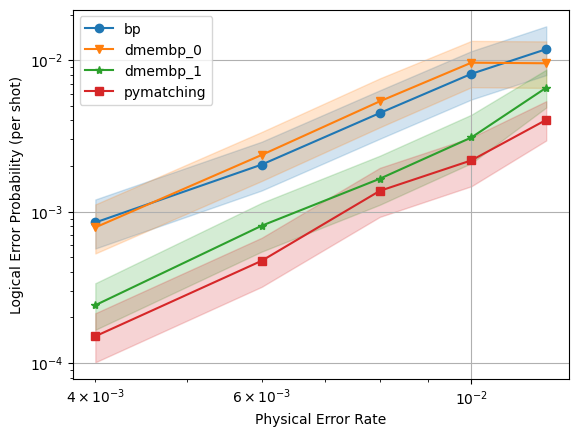

In [15]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"{stat.json_metadata['decoder']}",
    x_func=lambda stat: stat.json_metadata['p'],
)
ax.loglog()
# ax.set_ylim(1e-5, 1e-2)
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Physical Error Rate')
ax.legend()

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from qecdec import BPDecoder, DMemBPDecoder, RotatedSurfaceCode, detector_error_model_to_check_matrices
import pymatching

# Set up the experiment
d = 5
code = RotatedSurfaceCode(d)
num_shots = 100_000
seed = 42
error_rates = [0.004, 0.006, 0.008, 0.01, 0.012]

# Initialize data storage
results = {
    'error_rates': error_rates,
    'BP_syndromes': [],
    'BP_observables': [],
    'DMemBP_syndromes': [],
    'DMemBP_observables': [],
    'MWPM_syndromes': [],
    'MWPM_observables': []
}

# Run the comparison
for p in error_rates:
    print(f"Processing p = {p}...")
    
    circuit = code.make_circuit_memory_z_experiment(
        rounds=d,
        data_qubit_error_rate=p,
        meas_error_rate=p,
        keep_z_detectors_only=True,
    )
    syndromes, observables = circuit.compile_detector_sampler(seed=seed).sample(num_shots, separate_observables=True)
    syndromes = syndromes.astype(np.uint8)
    observables = observables.astype(np.uint8)

    dem = circuit.detector_error_model()
    matrices = detector_error_model_to_check_matrices(dem)
    chkmat = matrices.check_matrix.toarray().astype(np.uint8)
    obsmat = matrices.observables_matrix.toarray().astype(np.uint8)
    prior = matrices.priors.astype(np.float64)

    # BP Decoder
    bp = BPDecoder(
        pcm=chkmat,
        prior=prior,
        max_iter=50
    )
    ehat = bp.decode_batch(syndromes)
    syndromes_predict = (ehat @ chkmat.T) % 2
    num_unmatched_syndromes = np.sum(np.any(syndromes_predict != syndromes, axis=1))
    observables_predict = (ehat @ obsmat.T) % 2
    num_unmatched_observables = np.sum(np.any(observables_predict != observables, axis=1))
    
    results['BP_syndromes'].append(num_unmatched_syndromes)
    results['BP_observables'].append(num_unmatched_observables)

    # DMemBP Decoder
    dmembp = DMemBPDecoder(
        pcm=chkmat,
        prior=prior,
        gamma=gamma,
        max_iter=50
    )
    ehat = dmembp.decode_batch(syndromes)
    syndromes_predict = (ehat @ chkmat.T) % 2
    num_unmatched_syndromes = np.sum(np.any(syndromes_predict != syndromes, axis=1))
    observables_predict = (ehat @ obsmat.T) % 2
    num_unmatched_observables = np.sum(np.any(observables_predict != observables, axis=1))
    
    results['DMemBP_syndromes'].append(num_unmatched_syndromes)
    results['DMemBP_observables'].append(num_unmatched_observables)


    # MWPM Decoder
    mwpm = pymatching.Matching.from_check_matrix(chkmat, weights=np.log((1 - prior) / prior))
    ehat = mwpm.decode_batch(syndromes)
    syndromes_predict = (ehat @ chkmat.T) % 2
    num_unmatched_syndromes = np.sum(np.any(syndromes_predict != syndromes, axis=1))
    observables_predict = (ehat @ obsmat.T) % 2
    num_unmatched_observables = np.sum(np.any(observables_predict != observables, axis=1))
    
    results['MWPM_syndromes'].append(num_unmatched_syndromes)
    results['MWPM_observables'].append(num_unmatched_observables)

print("Data collection complete!")


Processing p = 0.004...
Processing p = 0.006...
Processing p = 0.008...
Processing p = 0.01...
Processing p = 0.012...
Data collection complete!


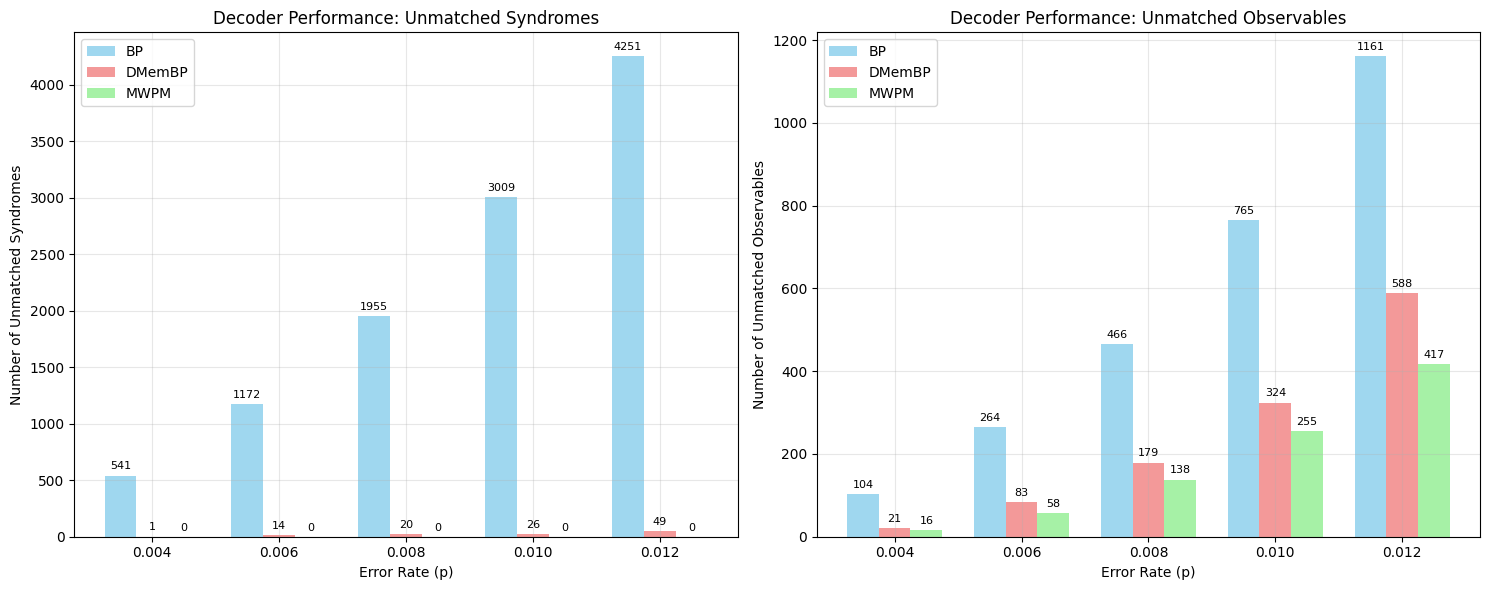


Summary Statistics:

Error Rate p = 0.004:
  BP:          541 unmatched syndromes,   104 unmatched observables
  DMemBP:        1 unmatched syndromes,    21 unmatched observables
  MWPM:          0 unmatched syndromes,    16 unmatched observables

Error Rate p = 0.006:
  BP:         1172 unmatched syndromes,   264 unmatched observables
  DMemBP:       14 unmatched syndromes,    83 unmatched observables
  MWPM:          0 unmatched syndromes,    58 unmatched observables

Error Rate p = 0.008:
  BP:         1955 unmatched syndromes,   466 unmatched observables
  DMemBP:       20 unmatched syndromes,   179 unmatched observables
  MWPM:          0 unmatched syndromes,   138 unmatched observables

Error Rate p = 0.010:
  BP:         3009 unmatched syndromes,   765 unmatched observables
  DMemBP:       26 unmatched syndromes,   324 unmatched observables
  MWPM:          0 unmatched syndromes,   255 unmatched observables

Error Rate p = 0.012:
  BP:         4251 unmatched syndromes,  1161 un

In [23]:
# Create bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Convert to numpy arrays for easier plotting
error_rates = np.array(results['error_rates'])
bp_syndromes = np.array(results['BP_syndromes'])
bp_observables = np.array(results['BP_observables'])
dmembp_syndromes = np.array(results['DMemBP_syndromes'])
dmembp_observables = np.array(results['DMemBP_observables'])
mwpm_syndromes = np.array(results['MWPM_syndromes'])
mwpm_observables = np.array(results['MWPM_observables'])

# Set up bar positions
x = np.arange(len(error_rates))
width = 0.25

# Plot 1: Unmatched Syndromes
bars1 = ax1.bar(x - width, bp_syndromes, width, label='BP', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x, dmembp_syndromes, width, label='DMemBP', alpha=0.8, color='lightcoral')
bars3 = ax1.bar(x + width, mwpm_syndromes, width, label='MWPM', alpha=0.8, color='lightgreen')

ax1.set_xlabel('Error Rate (p)')
ax1.set_ylabel('Number of Unmatched Syndromes')
ax1.set_title('Decoder Performance: Unmatched Syndromes')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{p:.3f}' for p in error_rates])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Plot 2: Unmatched Observables
bars4 = ax2.bar(x - width, bp_observables, width, label='BP', alpha=0.8, color='skyblue')
bars5 = ax2.bar(x, dmembp_observables, width, label='DMemBP', alpha=0.8, color='lightcoral')
bars6 = ax2.bar(x + width, mwpm_observables, width, label='MWPM', alpha=0.8, color='lightgreen')

ax2.set_xlabel('Error Rate (p)')
ax2.set_ylabel('Number of Unmatched Observables')
ax2.set_title('Decoder Performance: Unmatched Observables')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{p:.3f}' for p in error_rates])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars4, bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for i, p in enumerate(error_rates):
    print(f"\nError Rate p = {p:.3f}:")
    print(f"  BP:        {bp_syndromes[i]:5d} unmatched syndromes, {bp_observables[i]:5d} unmatched observables")
    print(f"  DMemBP:    {dmembp_syndromes[i]:5d} unmatched syndromes, {dmembp_observables[i]:5d} unmatched observables")
    print(f"  MWPM:      {mwpm_syndromes[i]:5d} unmatched syndromes, {mwpm_observables[i]:5d} unmatched observables")


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from qecdec import BPDecoder, DMemBPDecoder, RotatedSurfaceCode, detector_error_model_to_check_matrices
import pymatching

# Set up the experiment
d = 5
code = RotatedSurfaceCode(d)
num_shots = 100_000
seed = 42
error_rates = [0.004, 0.006, 0.008, 0.01, 0.012]

# Initialize data storage
results = {
    'error_rates': error_rates,
    'BP_syndromes': [],
    'BP_observables': [],
    'DMemBP_syndromes': [],
    'DMemBP_observables': [],
    'MWPM_syndromes': [],
    'MWPM_observables': []
}

# Run the comparison
for p in error_rates:
    print(f"Processing p = {p}...")
    
    circuit_phenom = code.make_circuit_memory_z_experiment(
        rounds=d,
        data_qubit_error_rate=p,
        meas_error_rate=p,
        keep_z_detectors_only=True,
    )
    circuit_circlevel = code.make_circuit_memory_z_experiment(
        rounds=d,
        data_qubit_error_rate=p,
        prep_error_rate=p,
        meas_error_rate=p,
        gate1_error_rate=p,
        gate2_error_rate=p,
        keep_z_detectors_only=True,
    )

    syndromes, observables = circuit_circlevel.compile_detector_sampler(seed=seed).sample(num_shots, separate_observables=True)
    syndromes = syndromes.astype(np.uint8)
    observables = observables.astype(np.uint8)

    dem = circuit_phenom.detector_error_model()
    matrices = detector_error_model_to_check_matrices(dem)
    chkmat = matrices.check_matrix.toarray().astype(np.uint8)
    obsmat = matrices.observables_matrix.toarray().astype(np.uint8)
    prior = matrices.priors.astype(np.float64)

    # BP Decoder
    bp = BPDecoder(
        pcm=chkmat,
        prior=prior,
        max_iter=50
    )
    ehat = bp.decode_batch(syndromes)
    syndromes_predict = (ehat @ chkmat.T) % 2
    num_unmatched_syndromes = np.sum(np.any(syndromes_predict != syndromes, axis=1))
    observables_predict = (ehat @ obsmat.T) % 2
    num_unmatched_observables = np.sum(np.any(observables_predict != observables, axis=1))
    
    results['BP_syndromes'].append(num_unmatched_syndromes)
    results['BP_observables'].append(num_unmatched_observables)

    # DMemBP Decoder
    dmembp = DMemBPDecoder(
        pcm=chkmat,
        prior=prior,
        gamma=gamma,
        max_iter=50
    )
    ehat = dmembp.decode_batch(syndromes)
    syndromes_predict = (ehat @ chkmat.T) % 2
    num_unmatched_syndromes = np.sum(np.any(syndromes_predict != syndromes, axis=1))
    observables_predict = (ehat @ obsmat.T) % 2
    num_unmatched_observables = np.sum(np.any(observables_predict != observables, axis=1))
    
    results['DMemBP_syndromes'].append(num_unmatched_syndromes)
    results['DMemBP_observables'].append(num_unmatched_observables)


    # MWPM Decoder
    mwpm = pymatching.Matching.from_check_matrix(chkmat, weights=np.log((1 - prior) / prior))
    ehat = mwpm.decode_batch(syndromes)
    syndromes_predict = (ehat @ chkmat.T) % 2
    num_unmatched_syndromes = np.sum(np.any(syndromes_predict != syndromes, axis=1))
    observables_predict = (ehat @ obsmat.T) % 2
    num_unmatched_observables = np.sum(np.any(observables_predict != observables, axis=1))
    
    results['MWPM_syndromes'].append(num_unmatched_syndromes)
    results['MWPM_observables'].append(num_unmatched_observables)

print("Data collection complete!")


Processing p = 0.004...
Processing p = 0.006...
Processing p = 0.008...
Processing p = 0.01...
Processing p = 0.012...
Data collection complete!


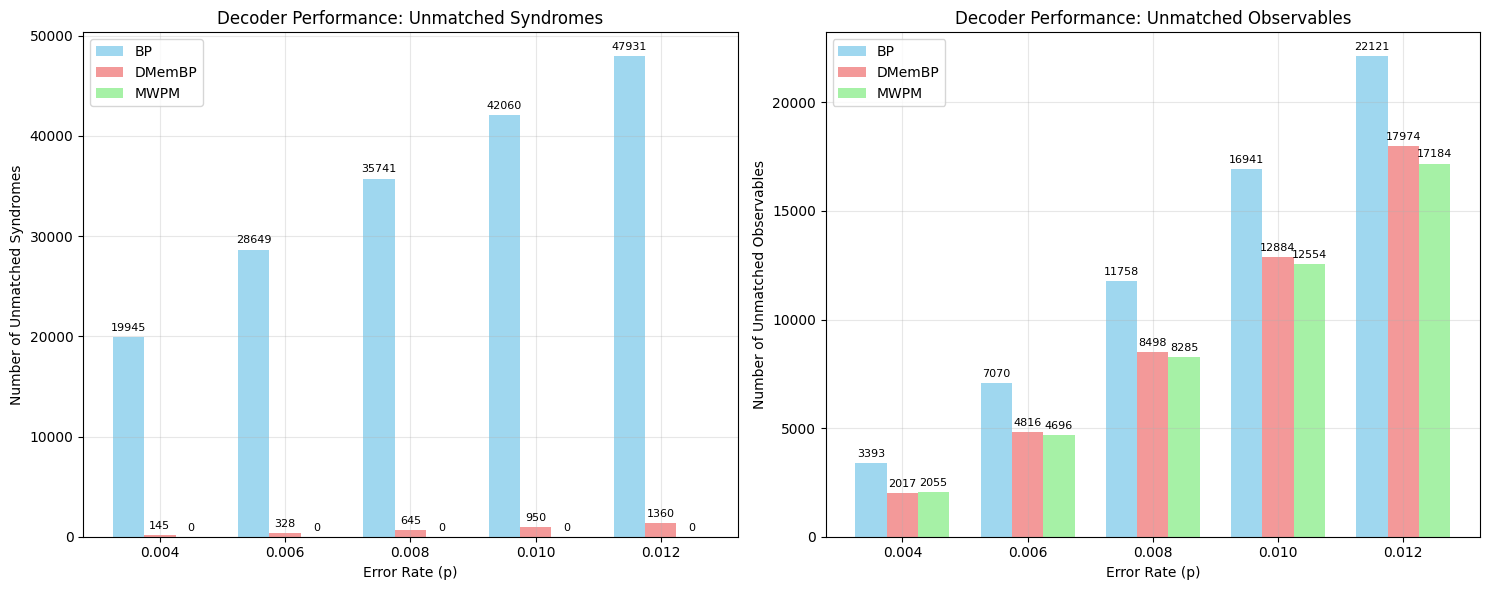


Summary Statistics:

Error Rate p = 0.004:
  BP:        19945 unmatched syndromes,  3393 unmatched observables
  DMemBP:      145 unmatched syndromes,  2017 unmatched observables
  MWPM:          0 unmatched syndromes,  2055 unmatched observables

Error Rate p = 0.006:
  BP:        28649 unmatched syndromes,  7070 unmatched observables
  DMemBP:      328 unmatched syndromes,  4816 unmatched observables
  MWPM:          0 unmatched syndromes,  4696 unmatched observables

Error Rate p = 0.008:
  BP:        35741 unmatched syndromes, 11758 unmatched observables
  DMemBP:      645 unmatched syndromes,  8498 unmatched observables
  MWPM:          0 unmatched syndromes,  8285 unmatched observables

Error Rate p = 0.010:
  BP:        42060 unmatched syndromes, 16941 unmatched observables
  DMemBP:      950 unmatched syndromes, 12884 unmatched observables
  MWPM:          0 unmatched syndromes, 12554 unmatched observables

Error Rate p = 0.012:
  BP:        47931 unmatched syndromes, 22121 un

In [25]:
# Create bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Convert to numpy arrays for easier plotting
error_rates = np.array(results['error_rates'])
bp_syndromes = np.array(results['BP_syndromes'])
bp_observables = np.array(results['BP_observables'])
dmembp_syndromes = np.array(results['DMemBP_syndromes'])
dmembp_observables = np.array(results['DMemBP_observables'])
mwpm_syndromes = np.array(results['MWPM_syndromes'])
mwpm_observables = np.array(results['MWPM_observables'])

# Set up bar positions
x = np.arange(len(error_rates))
width = 0.25

# Plot 1: Unmatched Syndromes
bars1 = ax1.bar(x - width, bp_syndromes, width, label='BP', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x, dmembp_syndromes, width, label='DMemBP', alpha=0.8, color='lightcoral')
bars3 = ax1.bar(x + width, mwpm_syndromes, width, label='MWPM', alpha=0.8, color='lightgreen')

ax1.set_xlabel('Error Rate (p)')
ax1.set_ylabel('Number of Unmatched Syndromes')
ax1.set_title('Decoder Performance: Unmatched Syndromes')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{p:.3f}' for p in error_rates])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Plot 2: Unmatched Observables
bars4 = ax2.bar(x - width, bp_observables, width, label='BP', alpha=0.8, color='skyblue')
bars5 = ax2.bar(x, dmembp_observables, width, label='DMemBP', alpha=0.8, color='lightcoral')
bars6 = ax2.bar(x + width, mwpm_observables, width, label='MWPM', alpha=0.8, color='lightgreen')

ax2.set_xlabel('Error Rate (p)')
ax2.set_ylabel('Number of Unmatched Observables')
ax2.set_title('Decoder Performance: Unmatched Observables')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{p:.3f}' for p in error_rates])
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars4, bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for i, p in enumerate(error_rates):
    print(f"\nError Rate p = {p:.3f}:")
    print(f"  BP:        {bp_syndromes[i]:5d} unmatched syndromes, {bp_observables[i]:5d} unmatched observables")
    print(f"  DMemBP:    {dmembp_syndromes[i]:5d} unmatched syndromes, {dmembp_observables[i]:5d} unmatched observables")
    print(f"  MWPM:      {mwpm_syndromes[i]:5d} unmatched syndromes, {mwpm_observables[i]:5d} unmatched observables")
